In [1]:
import xarray as xr
import numpy as np
import datetime as dt
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#data analysis libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
font = {'size': 14}

plt.rc('font', **font)
plt.style.use('tableau-colorblind10')

In [3]:
#getting label for output data

#importing data
GL_data = xr.open_dataset('data_use/GL_NCEP_gridded_air.nc')

#creating yearly winter averages
#averaging Dec, Jan, and Feb
#omitting first year of data because it doesn't have December

#getting months of data
months = np.asarray(pd.to_datetime(GL_data.time).month)

#getting years
years = GL_data.groupby('time.year').mean().year[1:]

#getting only winter months (DJF), leaving out 1950
GL_winter = GL_data.air[np.where((months == 12) | (months == 1) | (months == 2))][2:]

#averaging annually, converting to numpy
GL_DJF = np.zeros((72, 5, 9))
for i in np.arange(72):
    GL_DJF[i] = GL_winter[3*i:3*(i+1)].mean('time').to_numpy()
    
#creating new DataArray
GL_DJF = xr.DataArray(
    data = GL_DJF,
    dims = ['year', 'lat', 'lon'],
    coords = dict(
        year = years,
        lat = GL_data.lat,
        lon = GL_data.lon
    )
)

#standardizing data
scaler = StandardScaler()
GL_DJF_stan = scaler.fit_transform(GL_DJF.to_numpy().reshape(72, 45))


In [4]:
#using elbow method to find optimal number of clusters
k = np.arange(2,11)
inertias = np.zeros_like(k)
for i in np.arange(len(k)):
    inertias[i] = KMeans(n_clusters=k[i],random_state=42,n_init = 'auto').fit(GL_DJF_stan).inertia_

Text(0.5, 1.0, 'Elbow Method')

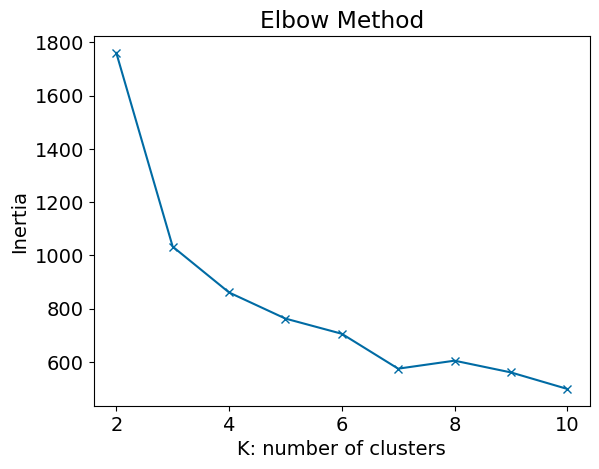

In [5]:
plt.plot(k,inertias, marker = 'x')
plt.xlabel('K: number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

In [6]:
#using KMeans with 2 clusters
kmeans2 = KMeans(n_clusters = 2, random_state = 42, n_init = 'auto')
kmeans2.fit(GL_DJF_stan)
kmeans2_labels = kmeans2.labels_

#using KMeans with 3 clusters
kmeans3 = KMeans(n_clusters = 3, random_state = 42, n_init = 'auto')
kmeans3.fit(GL_DJF_stan)
kmeans3_labels = kmeans3.labels_

In [7]:
#getting cluster centers
cc2 = kmeans2.cluster_centers_ * scaler.scale_ + scaler.mean_
cc2 = cc2.reshape(2, 5, 9) 

cc3 = kmeans3.cluster_centers_ * scaler.scale_ + scaler.mean_
cc3 = cc3.reshape(3, 5, 9) 

#converting to DataArray to plot:
centers_da2 = xr.DataArray(
    data=cc2,
    dims = ['n', 'lat', 'lon'],
    coords = dict(
        n= np.arange(2),
        lat = GL_winter.lat,
        lon = GL_winter.lon
    )
)

centers_da3 = xr.DataArray(
    data=cc3,
    dims = ['n', 'lat', 'lon'],
    coords = dict(
        n= np.arange(3),
        lat = GL_winter.lat,
        lon = GL_winter.lon
    )
)

In [8]:
#weights for spatial averaging
weights = np.cos(np.deg2rad(GL_winter.lat))

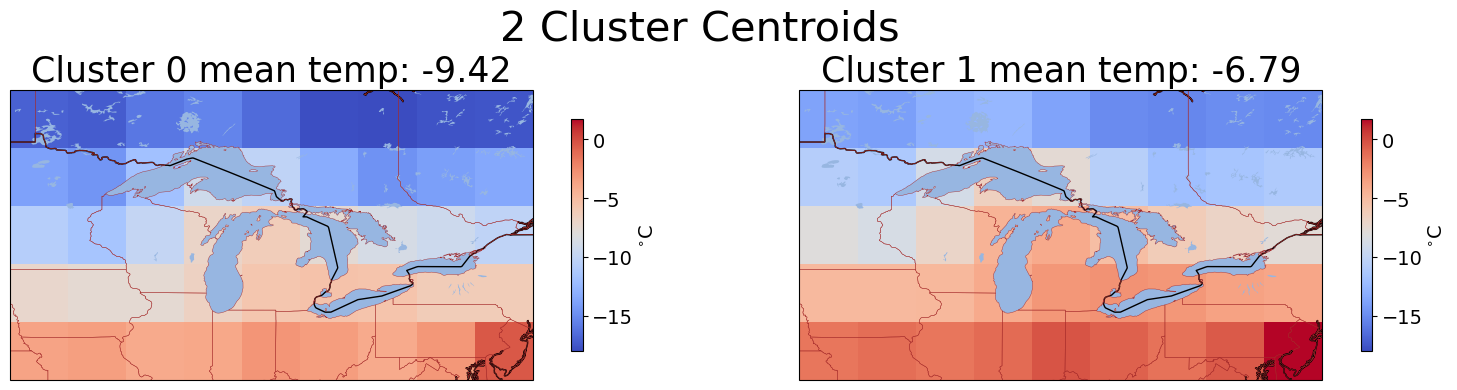

In [37]:
#plotting two cluster centroids
fig, ax = plt.subplots(1,2, figsize = (16, 4), subplot_kw = {'projection': ccrs.PlateCarree()})

vmin = np.min(centers_da2.to_numpy())
vmax = np.max(centers_da2.to_numpy())

#getting mean temperatures
mean_temp2 = centers_da2.weighted(weights).mean(('lat', 'lon'))

for i in np.arange(2):
    centers_da2[i].plot(ax = ax[i], vmin = vmin, vmax = vmax, cmap = 'coolwarm',
                        cbar_kwargs = {'shrink': .8, 'label': '$^{\circ }$C'})
    ax[i].set_xlabel('Longitude')
    ax[i].set_ylabel('Longitude')
    ax[i].set_title(f'Cluster {i} mean temp: {mean_temp2[i]:.2f}', fontsize = 25)
    
    #formatting
    ax[i].coastlines()
    ax[i].add_feature(cfeature.LAKES)
    ax[i].add_feature(cfeature.BORDERS)
    ax[i].add_feature(cfeature.STATES, linewidth=0.3, edgecolor='brown')

plt.suptitle('2 Cluster Centroids', fontsize = 30)
plt.tight_layout()
plt.savefig('report_figures/cluster_centroids.png')

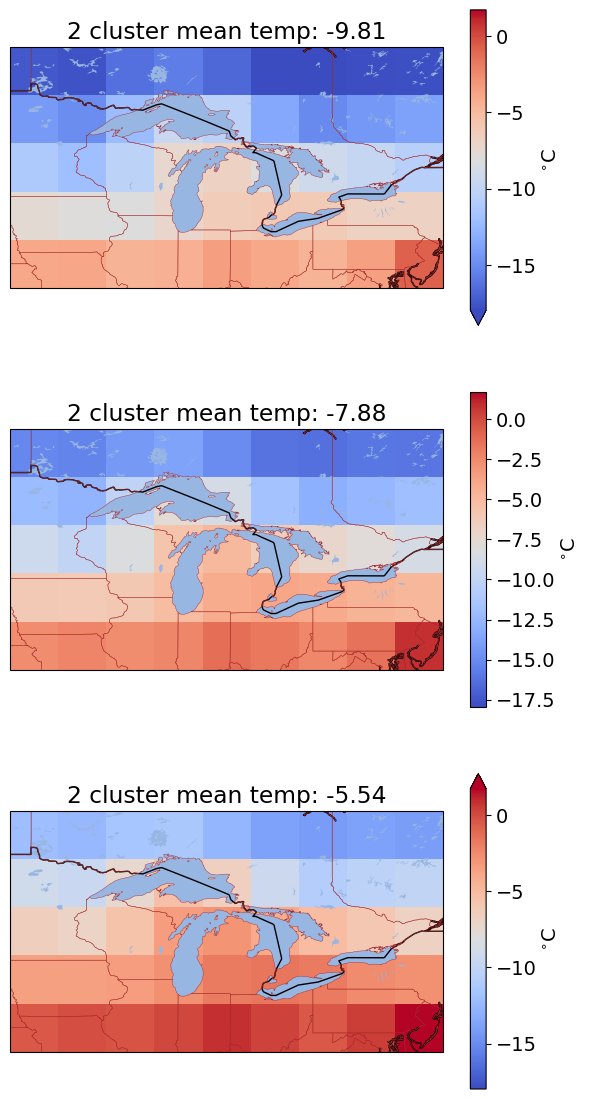

In [21]:
#plotting three cluster centroids
fig, ax = plt.subplots(3,1, figsize = (6, 12), subplot_kw = {'projection': ccrs.PlateCarree()})

vmin = np.min(centers_da2.to_numpy())
vmax = np.max(centers_da2.to_numpy())

#getting mean temperatures
mean_temp3 = centers_da3.weighted(weights).mean(('lat', 'lon'))

for i in np.arange(3):
    centers_da3[i].plot(ax = ax[i], vmin = vmin, vmax = vmax, cmap = 'coolwarm',
                        cbar_kwargs = {'shrink': .8, 'label': '$^{\circ }$C'})
    ax[i].set_xlabel('Longitude')
    ax[i].set_ylabel('Longitude')
    ax[i].set_title(f'2 cluster mean temp: {mean_temp3[i]:.2f}')
    
    #formatting
    ax[i].coastlines()
    ax[i].add_feature(cfeature.LAKES)
    ax[i].add_feature(cfeature.BORDERS)
    ax[i].add_feature(cfeature.STATES, linewidth=0.3, edgecolor='brown')
    
plt.tight_layout()

In [28]:
#getting average of each GL winter temperature
ave_winter_temps = GL_DJF.weighted(weights).mean(('lat', 'lon'))

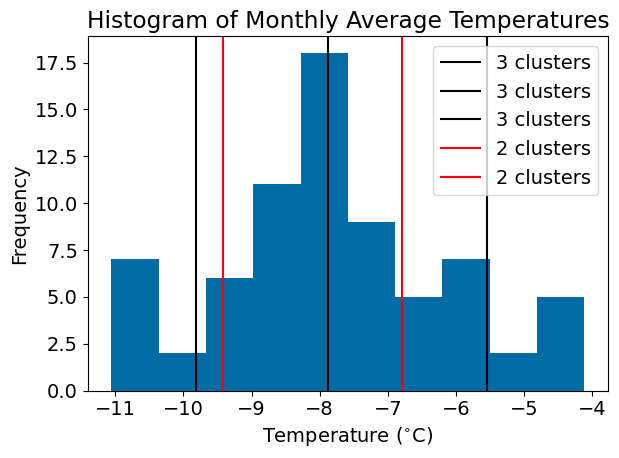

In [31]:
#creating histogram
plt.hist(ave_winter_temps)
for i in np.arange(3):
    plt.axvline(mean_temp3[i], c = 'k', label = '3 clusters')
for i in np.arange(2):
    plt.axvline(mean_temp2[i], c = 'r', label = '2 clusters')
plt.title('Histogram of Monthly Average Temperatures')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.savefig('report_figures/temperature_histogram.png')